In [2]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from finite_volume.advection import AdvectionSolver
from configs import problem_configs, solver_config
from utils import pd_xlsx_write

viridis = mpl.colormaps["viridis"]


def color_p(p):
    return viridis(p / 7)


                       worst     frequency          mean
         upper   9.90062e-05   0.00000e+00              
         lower  -1.94912e-19   9.98053e-01              
         total  -1.94912e-19   9.98053e-01  -1.76705e-20

solver.step_count=1540

                       worst     frequency          mean
         upper   4.86502e-05   0.00000e+00              
         lower  -2.81622e-19   9.96875e-01              
         total  -2.81622e-19   9.96875e-01  -3.66903e-20

solver.step_count=639

                       worst     frequency          mean
         upper   2.68722e-04   0.00000e+00              
         lower  -7.31362e-19   6.22972e-02              
         total  -7.31362e-19   6.22972e-02   6.25418e-18

solver.step_count=1540

                       worst     frequency          mean
         upper   2.16560e-04   0.00000e+00              
         lower  -2.12284e-11   6.14458e-02              
         total  -2.12284e-11   6.14458e-02  -1.10721e-13

solver.step_

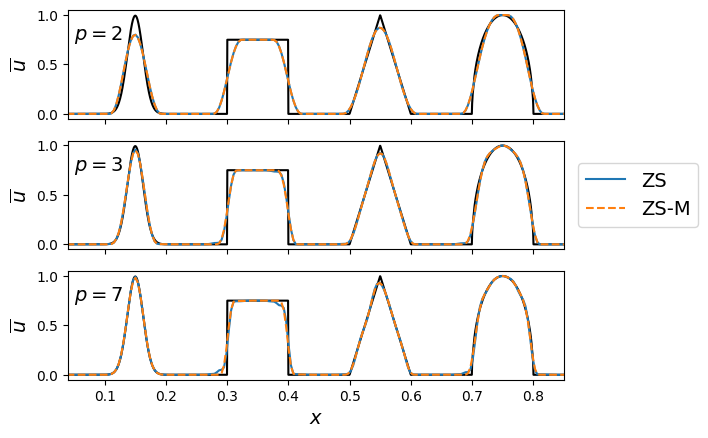

In [2]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)


high_res_initial_solver = AdvectionSolver(n=2056, **problem_configs["composite"])
for i in range(3):
    high_res_initial_solver.plot_slice(axs[i], color="black")

apriori_limiting_configs = [
    dict(apriori_limiting=True, courant="mpp", SED=True),
    dict(
        apriori_limiting=True,
        mpp_lite=True,
        courant=0.8,
        adaptive_stepsize=True,
        SED=True,
    ),
]

for (i, p), lc in product(enumerate([2, 3, 7]), apriori_limiting_configs):
    solver = AdvectionSolver(
        n=256,
        order=p + 1,
        snapshot_dt=0.1,
        num_snapshots=10,
        **lc,
        **problem_configs["composite"],
        **solver_config,
    )
    solver.highest = 3
    solver.rkorder()
    linestyle, label = ("--", "ZS-M") if lc.get("mpp_lite", False) else ("-", "ZS")
    solver.plot_slice(axs[i], linestyle=linestyle, label=label)
    solver.report_mpp_violations()
    print(f"{solver.step_count=}")

# cosmetics
fontsize = 14
axs[0].set_xlim(0.04, 0.85)
axs[0].text(
    0.05,
    0.8,
    "$p=2$",
    horizontalalignment="left",
    verticalalignment="center",
    size=fontsize,
)
axs[1].text(
    0.05,
    0.8,
    "$p=3$",
    horizontalalignment="left",
    verticalalignment="center",
    size=fontsize,
)
axs[2].text(
    0.05,
    0.8,
    "$p=7$",
    horizontalalignment="left",
    verticalalignment="center",
    size=fontsize,
)
axs[2].set_xlabel("$x$", fontsize=fontsize)
for i in range(3):
    axs[i].set_ylabel("$\overline{u}$", fontsize=fontsize)
axs[1].legend(loc="center", bbox_to_anchor=(1.15, 0.5), fontsize=fontsize)
fig.savefig("images/composite_ZS_vs_ZSM.png", dpi=300, bbox_inches="tight")

In [13]:
data = []
for C, integrator, p in product(["mpp"], ["SSPRK3", "RK4", "RK6"], [2, 3, 4, 5, 6, 7]):
    solver = AdvectionSolver(
        n=256,
        order=p + 1,
        snapshot_dt=0.1,
        num_snapshots=10,
        courant=C,
        apriori_limiting=True,
        SED=True,
        **problem_configs["composite"],
        **solver_config,
    )
    if integrator == "SSPRK3":
        if p < 2:
            continue
        solver.ssprk3()
    elif integrator == "RK4":
        if p < 3:
            continue
        solver.rk4()
    elif integrator == "RK6":
        if p < 4:
            continue
        solver.rk6()
    data.append(
        dict(
            p=p,
            integrator=integrator,
            delta=solver.compute_mpp_violations()[1]["worst"],
        )
    )
df = pd.DataFrame(data).sort_values(by="p")
df["integrator"] = df["integrator"].astype(
    pd.CategoricalDtype(["SSPRK3", "RK4", "RK6"], ordered=True)
)

print(
    pd.pivot_table(df, index="p", values="delta", columns="integrator").to_latex(
        float_format="%.2e"
    )
)

\begin{tabular}{lrrr}
\toprule
integrator & SSPRK3 & RK4 & RK6 \\
p &  &  &  \\
\midrule
2 & -1.95e-19 & NaN & NaN \\
3 & -7.31e-19 & -1.91e-19 & NaN \\
4 & -7.91e-23 & -1.07e-20 & -4.74e-06 \\
5 & -1.59e-21 & -1.86e-13 & -9.43e-09 \\
6 & -5.42e-22 & -1.35e-23 & -1.15e-07 \\
7 & -1.04e-19 & -1.10e-19 & -8.10e-10 \\
\bottomrule
\end{tabular}



p=1, delta_min=-0.01035278617520506
p=1, delta_min=-9.487862912533913e-11
p=2, delta_min=-0.00652252776089382
p=2, delta_min=-0.00014073373174709064
p=7, delta_min=-0.0003349662196586165
p=7, delta_min=-2.138206845238338e-07


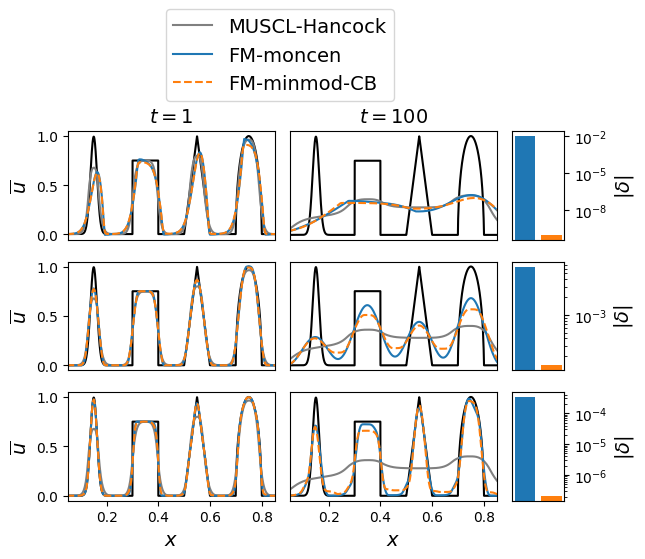

In [4]:
fig, axs = plt.subplots(3, 3, gridspec_kw={"width_ratios": [1, 1, 0.25]})
for i in range(3):
    axs[i, 2].set_yscale("log")
    axs[i, 2].yaxis.tick_right()
    axs[i, 2].yaxis.set_label_position("right")

# plot initial condition
high_res_initial_solver = AdvectionSolver(n=2056, **problem_configs["composite"])
for i, j in product((0, 1, 2), (0, 1)):
    high_res_initial_solver.plot_slice(axs[i, j], color="black")
    axs[i, j].set_xlim(0.05, 0.85)

# plot MUSCL-Hancock
MUSCL_Hancock_configs = [
    dict(
        cause_trouble=True,
        aposteriori_limiting=True,
        courant=0.8,
        hancock=True,
        fallback_limiter="minmod",
    ),
]

for i, (j, (snapshot_dt, num_snapshots)), (k, lc) in product(
    range(3), enumerate([(0.1, 10), (1.0, 100)]), enumerate(MUSCL_Hancock_configs)
):
    solver = AdvectionSolver(
        n=256,
        order=2,
        snapshot_dt=snapshot_dt,
        num_snapshots=num_snapshots,
        **lc,
        **problem_configs["composite"],
        **solver_config,
    )
    solver.euler()
    solver.plot_slice(axs[i, j], color="grey", label="MUSCL-Hancock")

# plot high order a posteriori limited solutions
limiter_configs = [
    dict(aposteriori_limiting=True, courant=0.8, fallback_limiter="moncen", SED=True),
    dict(
        aposteriori_limiting=True,
        courant=0.8,
        fallback_limiter="minmod",
        convex=True,
        SED=True,
    ),
]

for (i, p), (j, (snapshot_dt, num_snapshots)), (k, lc) in product(
    enumerate([1, 2, 7]), enumerate([(0.1, 10), (1.0, 100)]), enumerate(limiter_configs)
):
    solver = AdvectionSolver(
        n=256,
        order=p + 1,
        snapshot_dt=snapshot_dt,
        num_snapshots=num_snapshots,
        **lc,
        **problem_configs["composite"],
        **solver_config,
    )
    solver.rkorder()
    solver.plot_slice(
        axs[i, j],
        linestyle="--" if k == 1 else "-",
        label={0: "FM-moncen", 1: "FM-minmod-CB"}[k],
    )
    if j == 1:
        print(f"{p=}, delta_min={solver.compute_mpp_violations()[1]['worst']}")

    # plot on bar
    axs[i, 2].bar(
        [k],
        -solver.compute_mpp_violations()[1]["worst"],
        color={0: "tab:blue", 1: "tab:orange"}[k],
    )

# cosmetics
fontsize = 14
axs[1, 1].legend(loc="center", bbox_to_anchor=(-0.05, 2.9), fontsize=fontsize)
axs[0, 0].text(
    0.45,
    1.2,
    "$t=1$",
    size=fontsize,
    horizontalalignment="center",
    verticalalignment="center",
)
axs[0, 1].text(
    0.45,
    1.2,
    "$t=100$",
    size=fontsize,
    horizontalalignment="center",
    verticalalignment="center",
)
axs[2, 0].set_xlabel("$x$", fontsize=fontsize)
axs[2, 1].set_xlabel("$x$", fontsize=fontsize)
for i in range(3):
    axs[i, 1].get_yaxis().set_visible(False)
    axs[i, 0].set_ylabel("$\overline{u}$", fontsize=fontsize)
    axs[i, 2].get_xaxis().set_visible(False)
    axs[i, 2].set_ylabel("$|\delta|$", fontsize=fontsize)
    axs[i, 2].tick_params(axis="x", labelrotation=90)
for i, j in product((0, 1), (0, 1)):
    axs[i, j].get_xaxis().set_visible(False)
plt.subplots_adjust(wspace=0.1)
fig.savefig("images/composite_aposteriori_comparison.png", dpi=300, bbox_inches="tight")

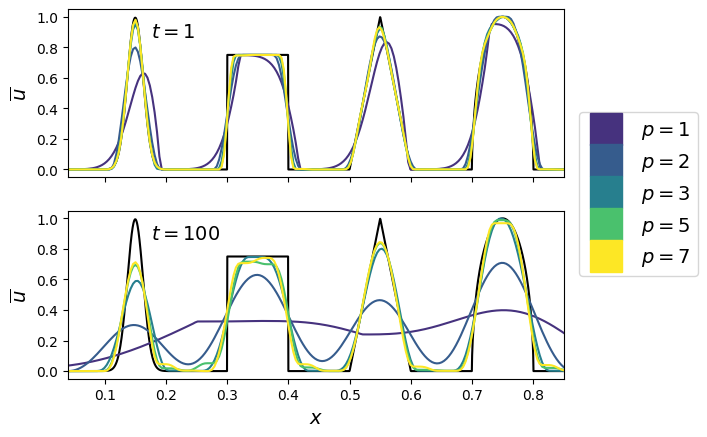

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# plot initial condition
high_res_initial_solver = AdvectionSolver(n=2056, **problem_configs["composite"])
for i in range(2):
    high_res_initial_solver.plot_slice(axs[i], color="black")
    axs[i].set_xlim(0.04, 0.85)

# plot high order a priori limited solutions
degrees = [1, 2, 3, 5, 7]
limiting_configs = [
    dict(
        apriori_limiting=True,
        mpp_lite=True,
        courant=0.8,
        adaptive_stepsize=True,
        SED=True,
    ),
]

for (i, p), (j, (snapshot_dt, num_snapshots)), (k, lc) in product(
    enumerate(degrees), enumerate([(0.1, 10), (1.0, 100)]), enumerate(limiting_configs)
):
    solver = AdvectionSolver(
        n=256,
        order=p + 1,
        snapshot_dt=snapshot_dt,
        num_snapshots=num_snapshots,
        **lc,
        **problem_configs["composite"],
        **solver_config,
    )
    solver.highest = 3
    solver.rkorder()
    solver.plot_slice(axs[j], color=color_p(p), label=f"${p=}$")

# cosmetics
leg = axs[0].legend(loc="center", bbox_to_anchor=(1.15, -0.1), fontsize=fontsize)
for line, p in zip(leg.get_lines(), degrees):
    line.set_linestyle("none")
    line.set_marker("s")
    line.set_markersize(23)
    line.set_markerfacecolor(color_p(p))
axs[1].set_xlabel("$x$", fontsize=fontsize)
for i in range(2):
    axs[i].set_ylabel("$\overline{u}$", fontsize=fontsize)
axs[0].text(
    0.175,
    0.9,
    "$t=1$",
    horizontalalignment="left",
    verticalalignment="center",
    size=fontsize,
)
axs[1].text(
    0.175,
    0.9,
    "$t=100$",
    horizontalalignment="left",
    verticalalignment="center",
    size=fontsize,
)
fig.savefig("images/composite_apriori_comparison.png", dpi=300, bbox_inches="tight")